# Evaluating different architecture for our Gunshot detection model

We recall from our preprocessing method comparison that using mel spectrograms is the most powerful preprocessing technique one can have to perform gunshot detection on our dataset. In this notebook, we compare different model architectures and design for our models to see which architecture design and tweaks can perform best. 

## Environment Setup 

### Package Imports

In [1]:
# Machine Learning imports
import torch
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from torchvision.models import resnet18, resnet34, resnet50, efficientnet_b1, efficientnet_b3, efficientnet_b5

# Processing imports
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Import the functions we designed to be used accross notebooks to avoid redundancies and improve clarity
from utils.common import list_files, create_dataframe, train_model, evaluate_model
from utils.datasets import BaseWaveformDataset, BaseSpectrogramDataset
from utils.plotsPreprocessing import plot_spectrogram, conv_display

### Global Variables

In [2]:
# Feel free to change the following in order to accommodate your environment
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
mode = "training" if str(device) == "cuda" else "development" 
print(f"Notebook in {mode} mode")

np.random.seed(4) # For reproducibility of results

MODEL_DIR = "models/architecture"
TRAIN_PREFIX = "Data/Training data"
VAL_PREFIX   = "Data/Validation data"

SAMPLE_RATE = 8000

Notebook in development mode


### Training Parameters

In [3]:
batch_size = 128
num_workers = 8 if str(device) == "cuda" else 2
num_epochs = 20
lr = 0.001

### Data Loading

In [4]:
train_keys = list_files(TRAIN_PREFIX)
val_keys   = list_files(VAL_PREFIX)

train_df   = create_dataframe(train_keys)
val_df     = create_dataframe(val_keys)

# Creating a Sampler to account for the imbalance of the dataset
train_counts = train_df["label"].value_counts().to_dict()
val_counts = val_df["label"].value_counts().to_dict()
weights = train_df["label"].map(lambda x: 1.0 / train_counts[x])
sampler = WeightedRandomSampler(weights.tolist(), num_samples=len(weights), replacement=True)

print(f"Found {len(train_keys)} training audios ({train_counts[1]} gunshots, {train_counts[0]} backgrounds) and {len(val_keys)} validation audios ({val_counts[1]} gunshots, {val_counts[0]} backgrounds).")

Found 28790 training audios (597 gunshots, 28193 backgrounds) and 7190 validation audios (150 gunshots, 7040 backgrounds).


## Mel-Spectrogram preprocessing pipeline

We standardise preprocessing with the Mel-Spectrogram method$\textemdash$the most performant in `preprocessingComparison.ipynb`

In [5]:
class MelDataset(BaseSpectrogramDataset):
    def process(self, waveform):
        spectrogram = T.MelSpectrogram(sample_rate=SAMPLE_RATE, n_fft=512, hop_length=128, n_mels=64)
        return spectrogram(waveform)

train_mel_spec = MelDataset(train_df, augmentation=0)
val_mel_spec = MelDataset(val_df)

In [6]:
train_loader_mel_spec = DataLoader(
    train_mel_spec,
    batch_size=batch_size,
    sampler=sampler,
    num_workers=num_workers,
    pin_memory=True
)
   
val_loader_mel_spec = DataLoader(
    val_mel_spec,
    batch_size=batch_size,
    num_workers=num_workers,
    pin_memory=True
)

## ResNet18 

### Default Architecture

In [7]:
resnet18_basic = resnet18(weights="IMAGENET1K_V1")
resnet18_basic.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet18_basic.fc = nn.Linear(resnet18_basic.fc.in_features, 2)

output_path_resnet18_basic = os.path.join(MODEL_DIR, "best_resnet18_basic.pth")
output_path_resnet18_basic2 = os.path.join(MODEL_DIR, "last_resnet18_basic.pth")

In [8]:
if mode == "training":
    train_model(resnet18_basic, train_loader_mel_spec, val_loader_mel_spec, output_path_resnet18_basic, output_path_resnet18_basic2, num_epochs, lr)
    evaluate_model("models/architecture/best_resnet18_basic.pth", val_loader_mel_spec)

### Adjusting the Kernel Size

Since gunshot are sudden occurences, we might want to reduce the kernel size.

#### Test 1 : Minor adjusment

In [9]:
resnet18_kernel_minor = resnet18(weights="IMAGENET1K_V1")
resnet18_kernel_minor.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=2, padding=3, bias=False)
resnet18_kernel_minor.fc = nn.Linear(resnet18_kernel_minor.fc.in_features, 2)

output_path_resnet18_kernel_minor = os.path.join(MODEL_DIR, "best_resnet18_kernel_minor.pth")
output_path_resnet18_kernel_minor2 = os.path.join(MODEL_DIR, "last_resnet18_kernel_minor.pth")

In [10]:
if mode == "training":
    train_model(resnet18_kernel_minor, train_loader_mel_spec, val_loader_mel_spec, output_path_resnet18_kernel_minor, output_path_resnet18_kernel_minor2, num_epochs, lr)
    evaluate_model("models/architecture/best_resnet18_kernel_minor.pth", val_loader_mel_spec)

#### Test 2 : Major adjusment

In [11]:
resnet18_kernel_major = resnet18(weights="IMAGENET1K_V1")
resnet18_kernel_major.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=3, bias=False)
resnet18_kernel_major.fc = nn.Linear(resnet18_kernel_major.fc.in_features, 2)

output_path_resnet18_kernel_major = os.path.join(MODEL_DIR, "best_resnet18_kernel_major.pth")
output_path_resnet18_kernel_major2 = os.path.join(MODEL_DIR, "last_resnet18_kernel_major.pth")

In [12]:
if mode == "training":
    train_model(resnet18_kernel_major, train_loader_mel_spec, val_loader_mel_spec, output_path_resnet18_kernel_major, output_path_resnet18_kernel_major2, num_epochs, lr)
    evaluate_model("models/architecture/best_resnet18_kernel_major.pth", val_loader_mel_spec)

### Adjusting the kernel dimensions

What matters most about a gunshot is that it is a very sudden event. An innovative technique could therefore be to change the dimension of the kernel of the gunshot to convolve the pixels with a kernel in the shape of a vertical rectangle rather than a square. One could also argue that what matters most regarding gunshot is their specific frequency. We could thus also experiment with horizontal rectangles. However, in our case, with different rifles present in the dataset, the high quantity of background shots, and the frequency of a gunshot typically being around 1kHz, this would the increase of likelihood of background events being classified as gunshots

The intuition here is that if you take the average of all the pixels at a given time, you will be able to isolate sudden occurences much more easily. To help visualise this change, we define a function (in `utils/plotPreprocessing.py`) that helps us visualise the impact of kernel dimension on spectrograms

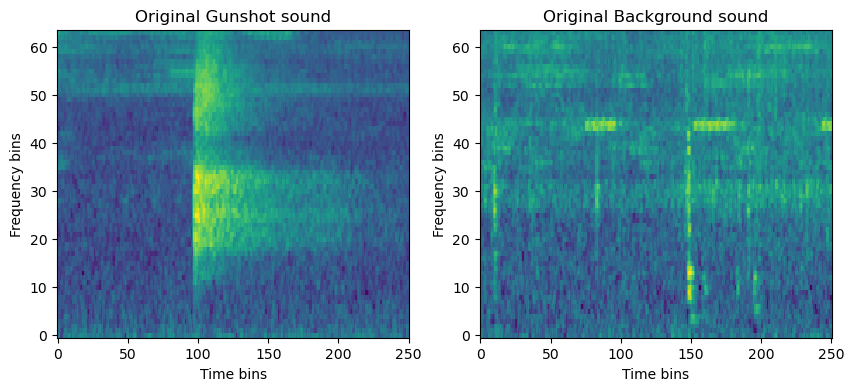

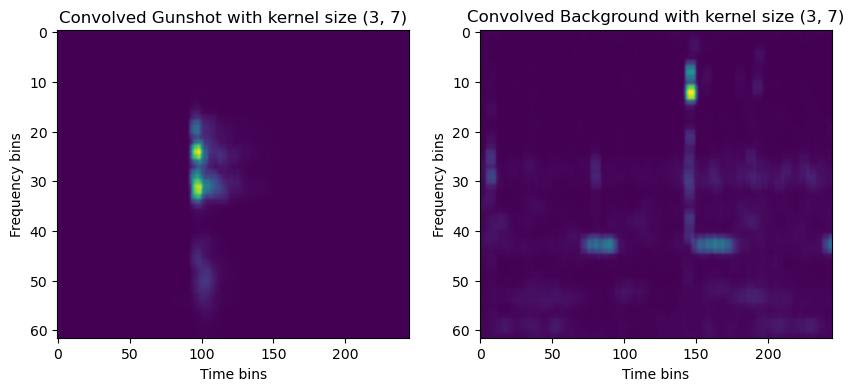

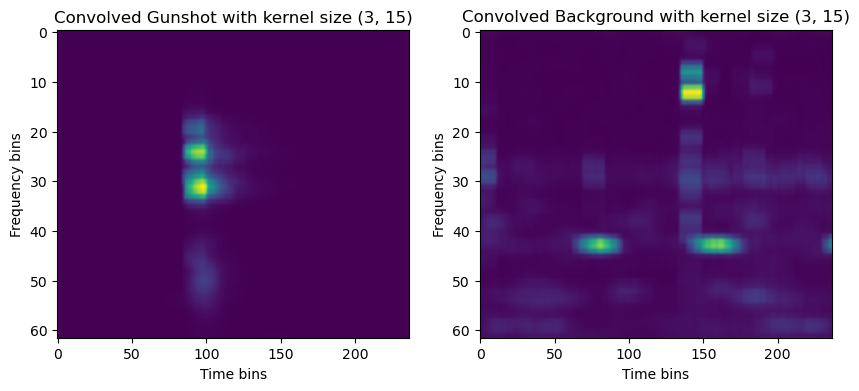

In [13]:
np.random.seed(4) # For reproducibility of results
pos_index, neg_index = -np.random.randint(0,train_counts[1]), np.random.randint(0,train_counts[0])

mel_spec_pos = train_mel_spec[pos_index][0]
mel_spec_neg = train_mel_spec[neg_index][0]

fig, axes = plt.subplots(1, 2, figsize=(10, 4))
plot_spectrogram(mel_spec_pos.squeeze(0), title="Original Gunshot sound", ax=axes[0])
plot_spectrogram(mel_spec_neg.squeeze(0), title="Original Background sound", ax=axes[1])

conv_display(mel_spec_pos, mel_spec_neg, 3, 7)
conv_display(mel_spec_pos, mel_spec_neg, 3, 15)

#### Test 1 : Minor adjusment

In [14]:
resnet18_rectangle_minor = resnet18(weights="IMAGENET1K_V1")
resnet18_rectangle_minor.conv1 = nn.Conv2d(1, 64, kernel_size=(3,7), stride=(2,2), padding=(1,3), bias=False)
resnet18_rectangle_minor.fc = nn.Linear(resnet18_rectangle_minor.fc.in_features, 2)

output_path_resnet18_rectangle_minor = os.path.join(MODEL_DIR, "best_resnet18_rectangle_minor.pth")
output_path_resnet18_rectangle_minor2 = os.path.join(MODEL_DIR, "last_resnet18_rectangle_minor.pth")

In [15]:
if mode == "training":
    train_model(resnet18_rectangle_minor, train_loader_mel_spec, val_loader_mel_spec, output_path_resnet18_rectangle_minor, output_path_resnet18_rectangle_minor2, num_epochs, lr)
    evaluate_model("models/architecture/best_resnet18_rectangle_minor.pth", val_loader_mel_spec)

#### Test 2 : Major adjusment

In [16]:
resnet18_rectangle_major = resnet18(weights="IMAGENET1K_V1")
resnet18_rectangle_major.conv1 = nn.Conv2d(1, 64, kernel_size=(3,15), stride=2, padding=(1,7), bias=False)
resnet18_rectangle_major.fc = nn.Linear(resnet18_rectangle_major.fc.in_features, 2)

output_path_resnet18_rectangle_major = os.path.join(MODEL_DIR, "best_resnet18_rectangle_major.pth")
output_path_resnet18_rectangle_major2 = os.path.join(MODEL_DIR, "last_resnet18_rectangle_major.pth")

In [17]:
if mode == "training":
    train_model(resnet18_rectangle_major, train_loader_mel_spec, val_loader_mel_spec, output_path_resnet18_rectangle_major, output_path_resnet18_rectangle_major2, num_epochs, lr)
    evaluate_model("models/architecture/best_resnet18_rectangle_major.pth", val_loader_mel_spec)

### Adjusting the depth
Another option can be to try out a different ResNet depth. Options that could work quite well even if it could potentially suffer from degradation are ResNet34 and ResNet50.

In [18]:
resnet34 = resnet34(weights="IMAGENET1K_V1")
resnet34.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet34.fc = nn.Linear(resnet34.fc.in_features, 2)

output_path_resnet34 = os.path.join(MODEL_DIR, "best_resnet34.pth")
output_path_resnet34 = os.path.join(MODEL_DIR, "last_resnet34.pth")

In [19]:
if mode == "training":
    train_model(resnet34, train_loader_mel_spec, val_loader_mel_spec, output_path_resnet34, output_path_resnet342, num_epochs, lr)
    evaluate_model("models/architecture/best_resnet34.pth", val_loader_mel_spec)

In [20]:
resnet50 = resnet50(weights="IMAGENET1K_V2")
resnet50.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
resnet50.fc = nn.Linear(resnet50.fc.in_features, 2)

output_path_resnet50 = os.path.join(MODEL_DIR, "best_resnet50.pth")
output_path_resnet50 = os.path.join(MODEL_DIR, "last_resnet50.pth")

In [21]:
if mode == "training":
    train_model(resnet50, train_loader_mel_spec, val_loader_mel_spec, output_path_resnet50, output_path_resnet502, num_epochs, lr)
    evaluate_model("models/architecture/best_resnet50.pth", val_loader_mel_spec)

### Conclusion

## EfficientNets
Given our focus on performance in this section, we will compare heavier EfficientNet models

### Our baseline choice : EfficientNet-B3

In [22]:
EfficientNetB3 = efficientnet_b3(weights="IMAGENET1K_V1")
EfficientNetB3.conv1 = nn.Conv2d(1, 48, kernel_size=3, stride=2, padding=1, bias=False)
EfficientNetB3.classifier[1] = nn.Linear(EfficientNetB3.classifier[1].in_features, 2)

output_path_EfficientNetB3 = os.path.join(MODEL_DIR, "best_EfficientNetB3.pth")
output_path_EfficientNetB3 = os.path.join(MODEL_DIR, "last_EfficientNetB3.pth")

Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to /home/sagemaker-user/.cache/torch/hub/checkpoints/efficientnet_b3_rwightman-b3899882.pth
100%|██████████| 47.2M/47.2M [00:00<00:00, 118MB/s] 


In [23]:
if mode == "training":
    train_model(EfficientNetB3, train_loader_mel_spec, val_loader_mel_spec, output_path_EfficientNetB3, output_path_EfficientNetB32, num_epochs, lr)
    evaluate_model("models/architecture/best_EfficientNetB3.pth", val_loader_mel_spec)

### A shallower option : EfficientNet-B1
Comparing EfficientNet-B3 to this model allows us to check that our dataset is large enough and of high enough quality. 

In [24]:
EfficientNetB1 = efficientnet_b1(weights="IMAGENET1K_V1")
EfficientNetB1.conv1 = nn.Conv2d(1, 48, kernel_size=3, stride=2, padding=1, bias=False)
EfficientNetB1.classifier[1] = nn.Linear(EfficientNetB1.classifier[1].in_features, 2)

output_path_EfficientNetB1 = os.path.join(MODEL_DIR, "best_EfficientNetB1.pth")
output_path_EfficientNetB1 = os.path.join(MODEL_DIR, "last_EfficientNetB1.pth")

Downloading: "https://download.pytorch.org/models/efficientnet_b1_rwightman-bac287d4.pth" to /home/sagemaker-user/.cache/torch/hub/checkpoints/efficientnet_b1_rwightman-bac287d4.pth
100%|██████████| 30.1M/30.1M [00:00<00:00, 139MB/s]


In [25]:
if mode == "training":
    train_model(EfficientNetB1, train_loader_mel_spec, val_loader_mel_spec, output_path_EfficientNetB1, output_path_EfficientNetB12, num_epochs, lr)
    evaluate_model("models/architecture/best_EfficientNetB1.pth", val_loader_mel_spec)

### A deeper option : EfficientNet-B5
Now, given that we checked that EfficientNet-B3 does not suffer from lack of training data, it is reasonable to attempt training an even bigger network

In [26]:
EfficientNetB5 = efficientnet_b5(weights="IMAGENET1K_V1")
EfficientNetB5.conv1 = nn.Conv2d(1, 48, kernel_size=3, stride=2, padding=1, bias=False)
EfficientNetB5.classifier[1] = nn.Linear(EfficientNetB5.classifier[1].in_features, 2)

output_path_EfficientNetB5 = os.path.join(MODEL_DIR, "best_EfficientNetB5.pth")
output_path_EfficientNetB5 = os.path.join(MODEL_DIR, "last_EfficientNetB5.pth")

Downloading: "https://download.pytorch.org/models/efficientnet_b5_lukemelas-1a07897c.pth" to /home/sagemaker-user/.cache/torch/hub/checkpoints/efficientnet_b5_lukemelas-1a07897c.pth
100%|██████████| 117M/117M [00:00<00:00, 146MB/s] 


In [27]:
if mode == "training":
    train_model(EfficientNetB5, train_loader_mel_spec, val_loader_mel_spec, output_path_EfficientNetB5, output_path_EfficientNetB52, num_epochs, lr)
    evaluate_model("models/architecture/best_EfficientNetB5.pth", val_loader_mel_spec)

### Conclusion

### Default Architecture

### Adjusting the ...

### Adjusting the ...

### Adjusting the ...

### Conclusion
X is best

## Results

*Table*